In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="LogP",ascending=False)
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
914,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(CC4CCC4)CC3)...,9.22,572.939,8.7937,0.331566
1340,CC(C1CC1)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2...,9.52,572.939,8.7921,0.331570
1287,CC(C)(C)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c...,9.70,560.928,8.7921,0.347371
116,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(C4CCC4)CC3)c...,9.40,558.912,8.5461,0.348159
988,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(CC4CC4)CC3)c...,9.30,558.912,8.4036,0.341183
...,...,...,...,...,...
1397,Cn1c(-c2cn(C3OC(C(=O)O)C(O)C(O)C3O)nn2)nc(-c2c...,6.23,496.455,0.6114,0.307129
731,OC1OC(Cn2cc(-c3nc(-c4ccc(F)cc4)c(-c4ccncc4)o3)...,5.24,469.429,0.6011,0.325894
960,Cn1c(=O)c(Oc2ccc(F)cc2F)cc2c[nH]c(=NC(CO)CO)nc21,6.80,378.335,0.5860,0.601426
215,Cn1c(-c2cn(C3C(O)OC(CO)C(O)C3O)nn2)nc(-c2ccc(F...,6.07,482.472,0.5191,0.319000


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_xgboost_training batches.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_xgboost_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df,false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.5081856536231333, 7.923398604690565e-11)
(0.6983560140619454, 2.259451460243186e-22)
(0.6887354707591391, 1.4215992383536774e-21)
(0.774900205406681, 4.403346540240243e-30)
(0.7049026771075063, 6.195904935909586e-23)
(0.7866807780074647, 1.5270680862135084e-31)
(0.7945532891407433, 1.4312265713059477e-32)
(0.7235337798791628, 1.2742711438033063e-24)
(0.7120528388851889, 2.427969029280135e-24)


In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(0, 3)
(1, 3)
(4, 3)
(2, 3)
(0, 3)
(1, 3)
(1, 3)
(0, 3)
(2, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(0, 3)
(0, 3)
(1, 3)
(5, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(3, 3)
(7, 3)
(4, 3)
(1, 3)
(2, 3)
(5, 3)
(2, 3)
(8, 3)
(7, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(141, 3)
(136, 3)
(134, 3)
(136, 3)
(141, 3)
(138, 3)
(140, 3)
(136, 3)
(140, 3)


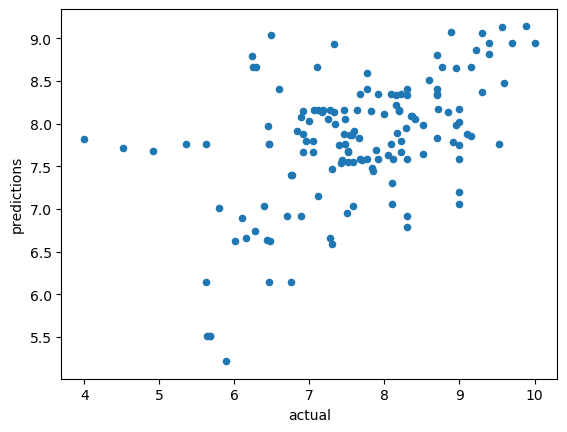

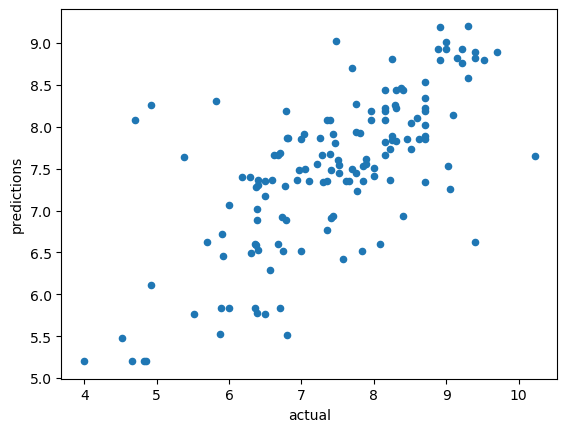

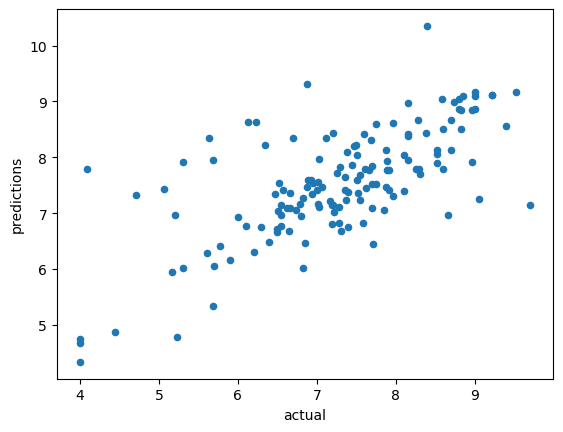

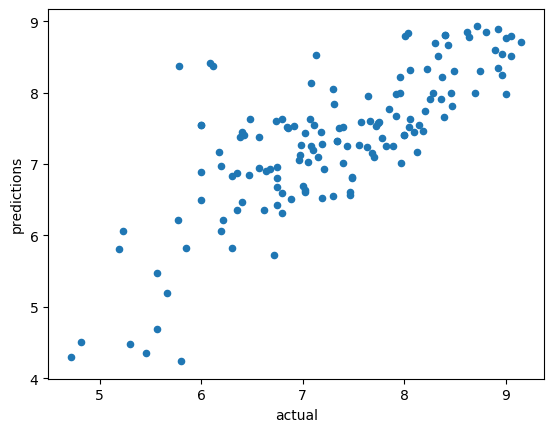

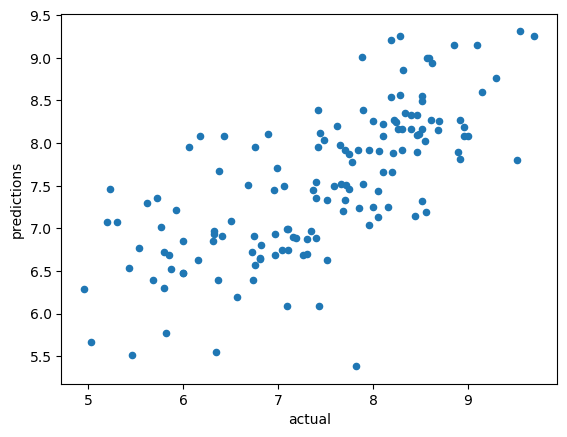

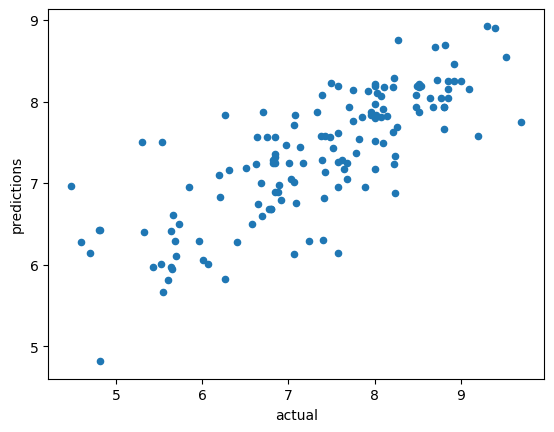

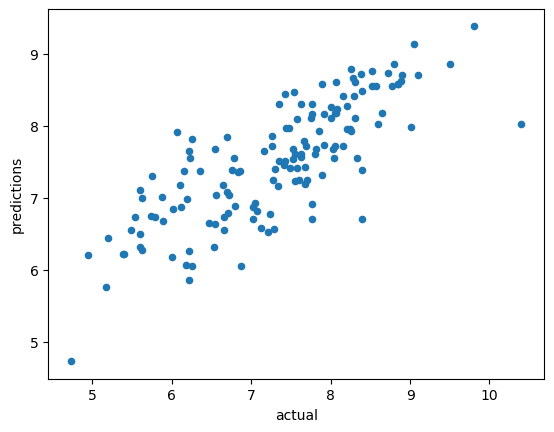

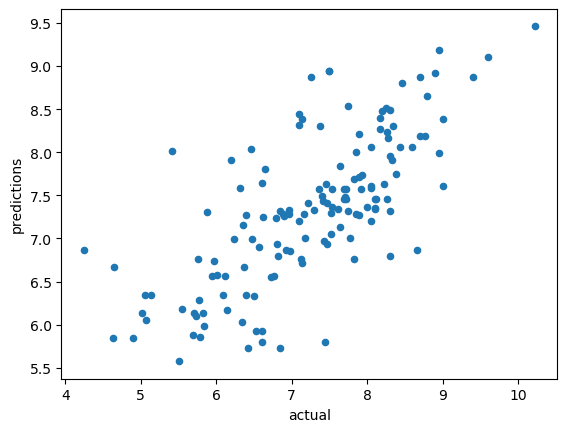

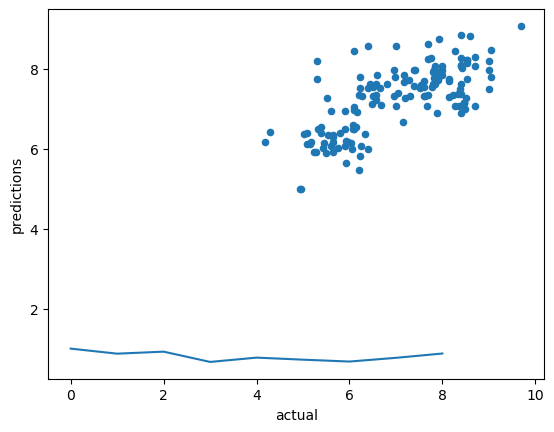

[1.0034263528855139, 0.8775423952354918, 0.9277812726326955, 0.6710828953876575, 0.778321365179318, 0.7275339946356171, 0.6803642464697768, 0.7735727641952004, 0.8811665012944598]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

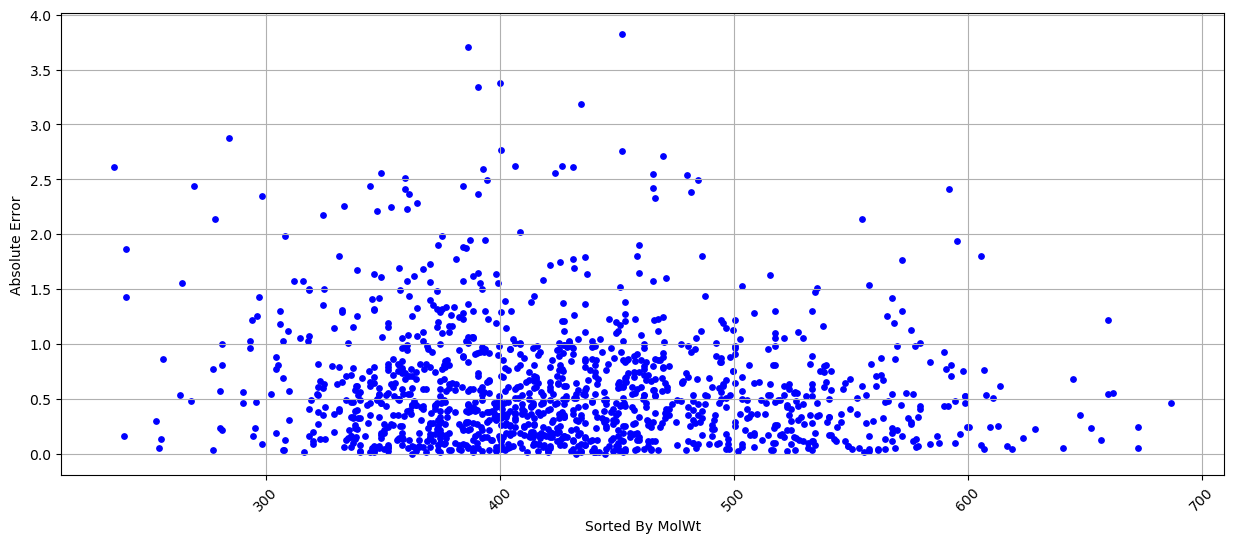

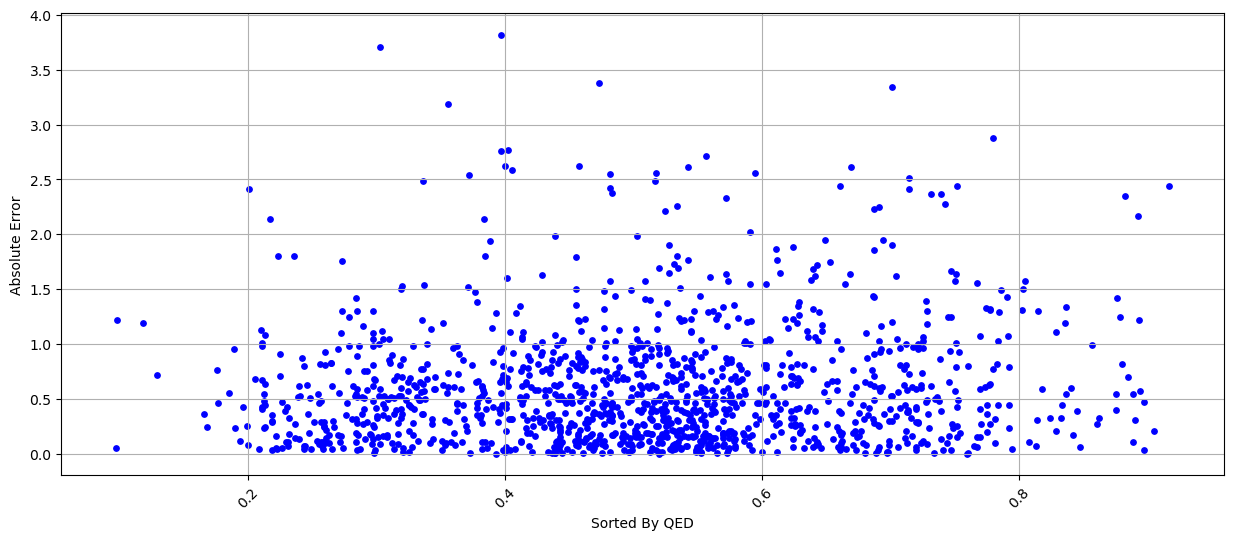

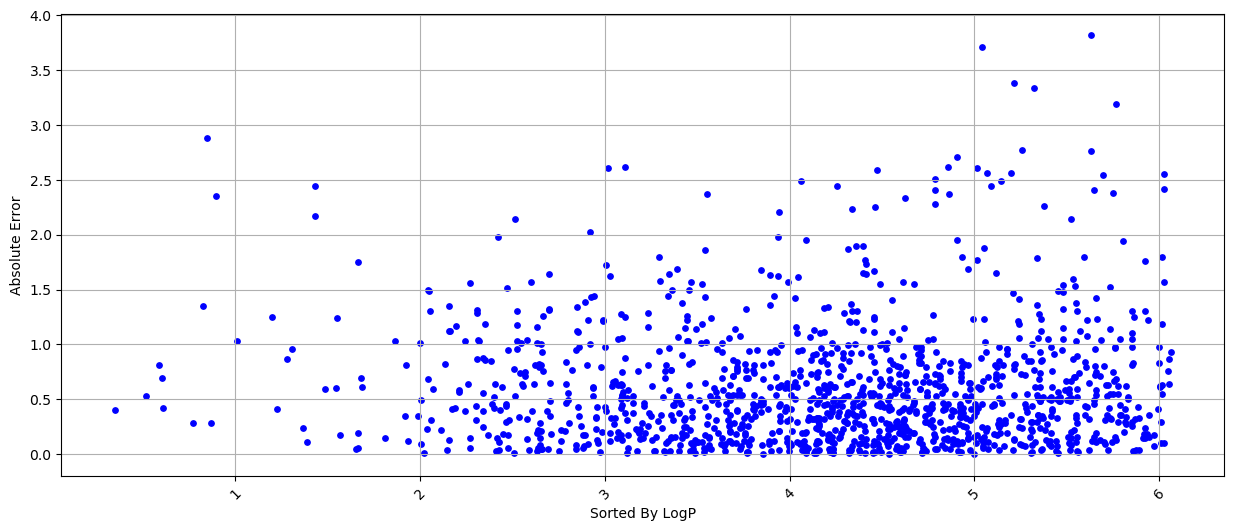

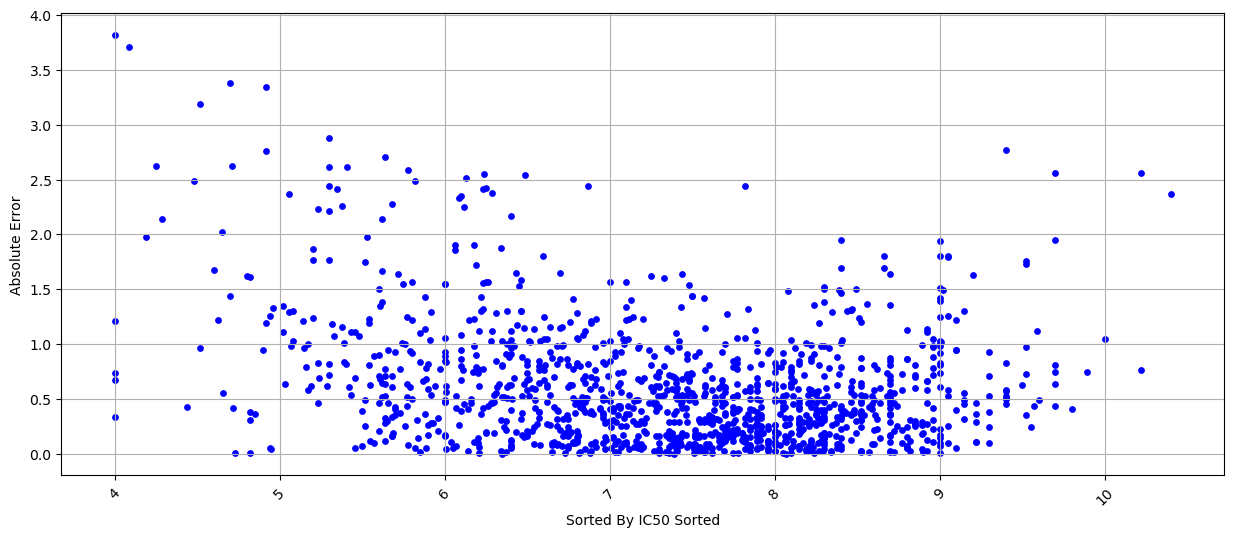

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
914,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(CC4CCC4)CC3)...,9.22,572.939,8.7937,0.331566,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1340,CC(C1CC1)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2...,9.52,572.939,8.7921,0.331570,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1287,CC(C)(C)N1CCC(c2cc(-c3ccc(F)cc3Cl)c3c(c2)N(c2c...,9.70,560.928,8.7921,0.347371,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(C4CCC4)CC3)c...,9.40,558.912,8.5461,0.348159,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
988,O=C1NCc2c(-c3ccc(F)cc3Cl)cc(C3CCN(CC4CC4)CC3)c...,9.30,558.912,8.4036,0.341183,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1397,Cn1c(-c2cn(C3OC(C(=O)O)C(O)C(O)C3O)nn2)nc(-c2c...,6.23,496.455,0.6114,0.307129,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
731,OC1OC(Cn2cc(-c3nc(-c4ccc(F)cc4)c(-c4ccncc4)o3)...,5.24,469.429,0.6011,0.325894,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
960,Cn1c(=O)c(Oc2ccc(F)cc2F)cc2c[nH]c(=NC(CO)CO)nc21,6.80,378.335,0.5860,0.601426,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
215,Cn1c(-c2cn(C3C(O)OC(CO)C(O)C3O)nn2)nc(-c2ccc(F...,6.07,482.472,0.5191,0.319000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_xgboost_training batches_druglike.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_xgboost_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.3511919932611915, 1.5898139635738687e-05)
(0.2703130348693962, 0.0010502562375296406)
(0.1780357380546313, 0.03276956090519011)
(0.3647157304031063, 6.981866942360668e-06)
(0.45102132240798787, 1.4028291705482368e-08)
(0.25062977459953567, 0.0024467024642805713)
(0.49190988243403677, 3.8165794262245296e-10)
(0.5258419332780346, 1.3071668599532473e-11)
(0.7255001181338796, 8.301916675393455e-25)


In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(2, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(3, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(0, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(135, 3)
(135, 3)
(135, 3)
(132, 3)
(135, 3)
(134, 3)
(135, 3)
(135, 3)
(135, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(7, 3)


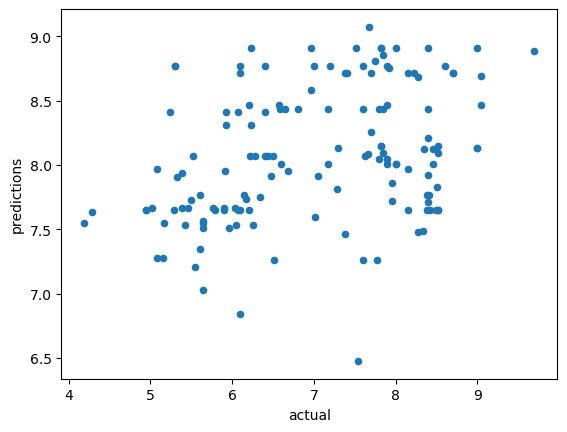

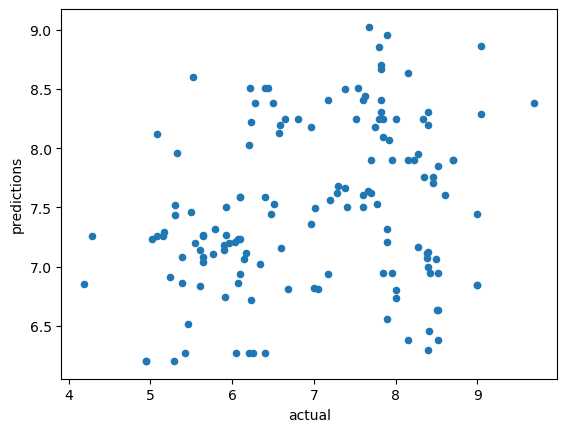

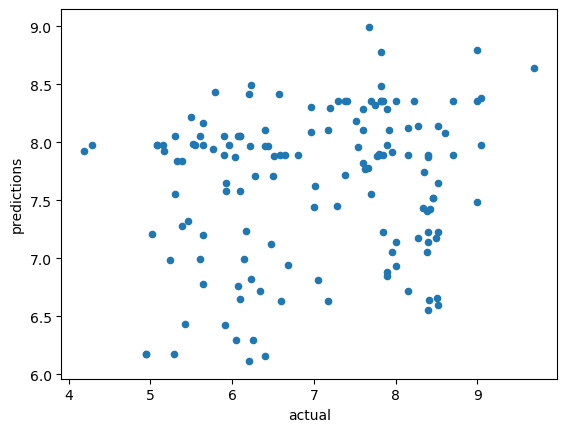

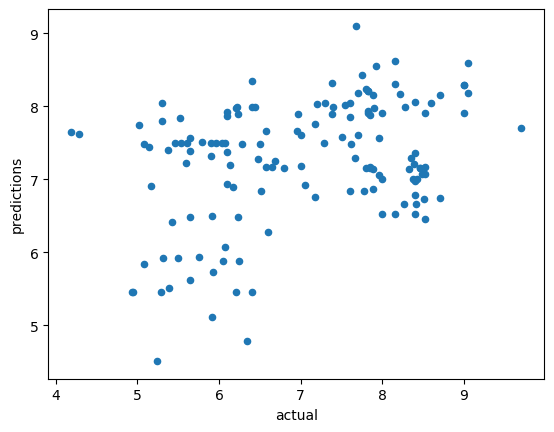

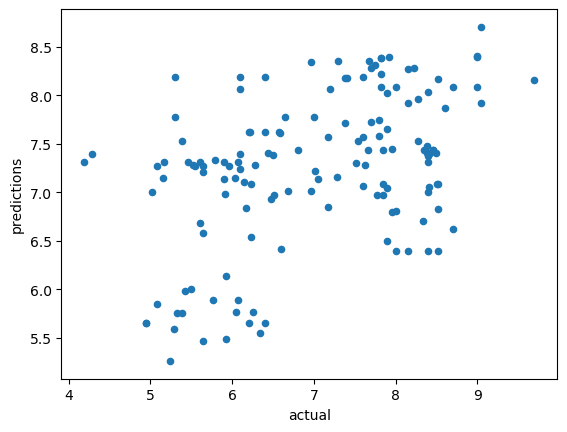

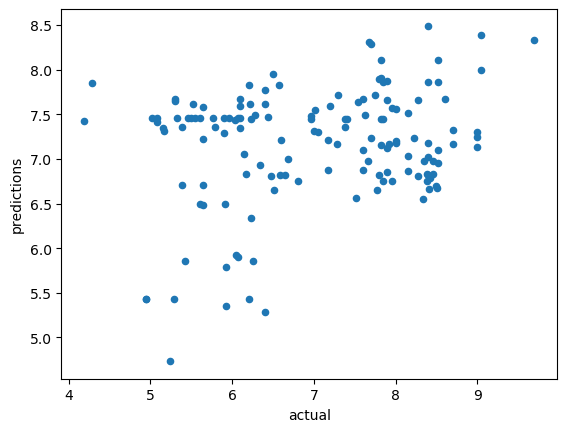

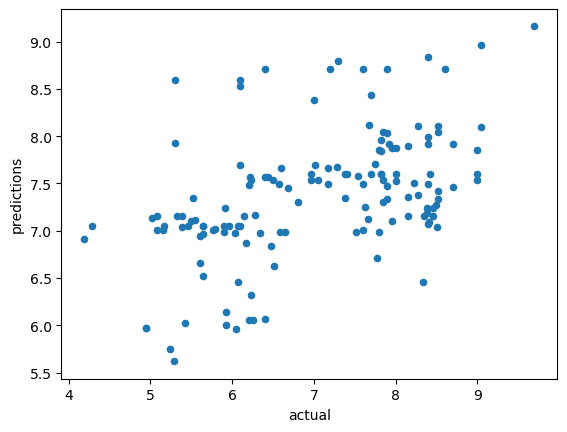

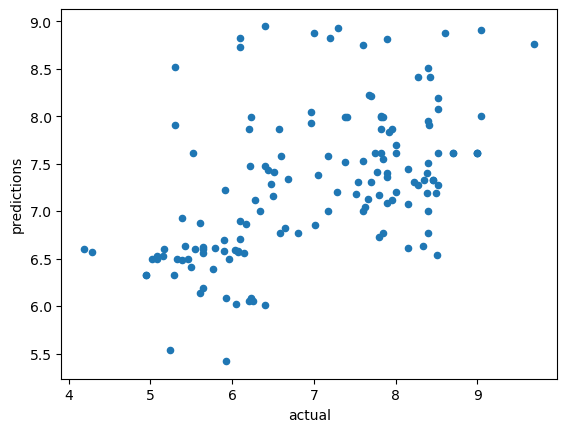

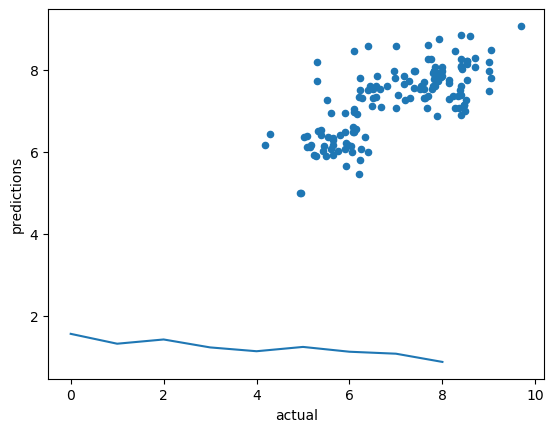

[1.56092738484921, 1.3199962015962377, 1.4234957164403004, 1.2299389006198242, 1.1367496461397921, 1.2418802504379884, 1.1245006530628703, 1.0764595828697319, 0.8759622979916536]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)